In [1]:
# Importing everything at the beginning to be sure that there is no import errors

import numpy as np 
import pandas as pd

import re
import string
from itertools import islice

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

import nltk
from nltk.corpus import twitter_samples

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import TensorBoard

import wandb
from wandb.keras import WandbCallback

import missingno as msnum

import operator

from wordcloud import WordCloud
from termcolor import colored

import warnings
warnings.filterwarnings(action="ignore")

In [2]:
df = pd.read_csv('train.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# Data Visualization

In [3]:
# Gaining some insight on data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


### Conclusion:
 - Dataset is having (7613, 5) shape including the features and target label.
 - 'keyword', 'location', 'text' are object dtype
 - 'id', 'target' are int dtypes

In [4]:
# Checking data stats for numerical features

df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,7613.0,5441.934848,3137.11609,1.0,2734.0,5408.0,8146.0,10873.0
target,7613.0,0.429660,0.49506,0.0,0.0,0.0,1.0,1.0


In [5]:
# Checking data stats for non-numerical features

df.describe(include="O").T

,count,unique,top,freq
keyword,7552,221,fatalities,45
location,5080,3341,USA,104
text,7613,7503,11-Year-Old Boy Charged With Manslaughter of T...,10


### Conclusion:
 - dataset has 7552 keywords, only 221 of which are unique
 - dataset has 5080 locatoins, 3341 of which are unique
 - dataset has 7613 texts (tweets), 7503 of which are unique
 - above data indicates that some tweets might be duplicates

In [6]:
# Cheching if there is nulls, we already know there is nulls from df.info() but this is easier to read

df.isnull().any()

id          False
keyword      True
location     True
text        False
target      False
dtype: bool

In [7]:
# Number of nulls for each column

df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [8]:
# Percentage of nulls for each column

round((((df.isnull().sum())/len(df.index))*100),2)

id           0.00
keyword      0.80
location    33.27
text         0.00
target       0.00
dtype: float64

<AxesSubplot:>

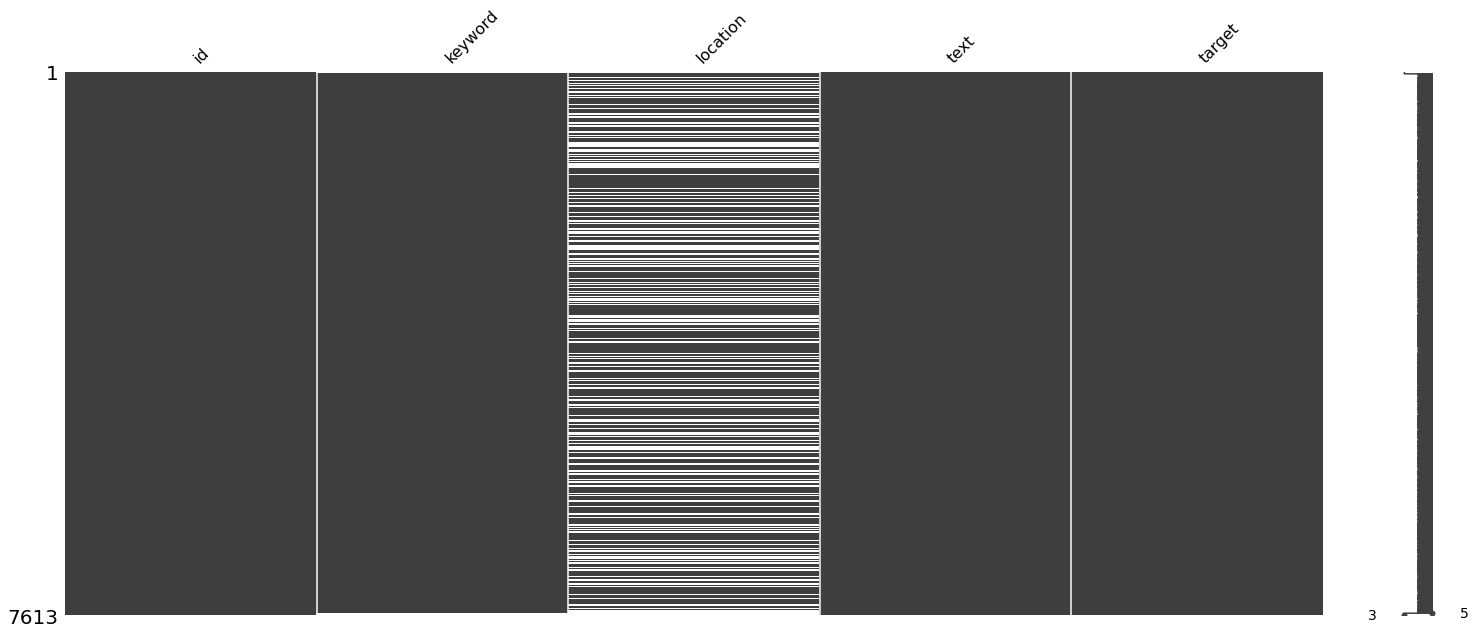

In [9]:
# Visualizing nulls

msnum.matrix(df)

### Conclusion:
 - 61 keywords are nulls which is ~0.8% of the dataset length
 - 2533 locations are nulls which is ~33% of the dataset length
 - number of null locations is huge so we might need to drop the 'locations' column

In [10]:
# Top 15 locations

n = 15
lcs = df['location'].value_counts().index.tolist()[:n]
lcsCount = df['location'].value_counts().values.tolist()[:n]

TopLocations = pd.DataFrame(list(zip(lcs, lcsCount)), columns =['Location', 'Count']).T
TopLocations

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Location,USA,New York,United States,London,Canada,Nigeria,UK,"Los Angeles, CA",India,Mumbai,"Washington, DC",Kenya,Worldwide,"Chicago, IL",Australia
Count,104,71,50,45,29,28,27,26,24,22,21,20,19,18,18


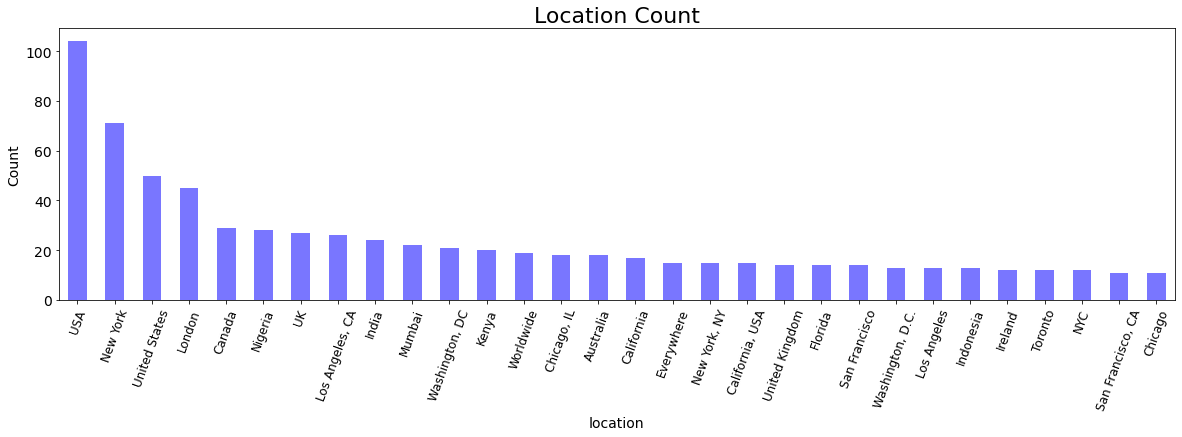

In [11]:
# Visualizing top 15 locations

plt.figure(figsize=(20, 5))
df.location.value_counts().sort_values(ascending=False)[:30].plot(kind="bar",
                                                                  color="#7976FF",
                                                                  linewidth=2,
                                                                  fontsize=14);
plt.title('Location Count', fontsize = 22)
plt.xlabel('location', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.xticks(fontsize=12, rotation=70);

In [12]:
# Top 15 keywords

n = 15
kw = df['keyword'].value_counts().index.tolist()[:n]
kwCount = df['keyword'].value_counts().values.tolist()[:n]

TopKeywords = pd.DataFrame(list(zip(kw, kwCount)), columns =['keyword', 'Count']).T
TopKeywords

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
keyword,fatalities,armageddon,deluge,harm,sinking,body%20bags,damage,siren,twister,evacuate,windstorm,fear,collided,outbreak,earthquake
Count,45,42,42,41,41,41,41,40,40,40,40,40,40,40,39


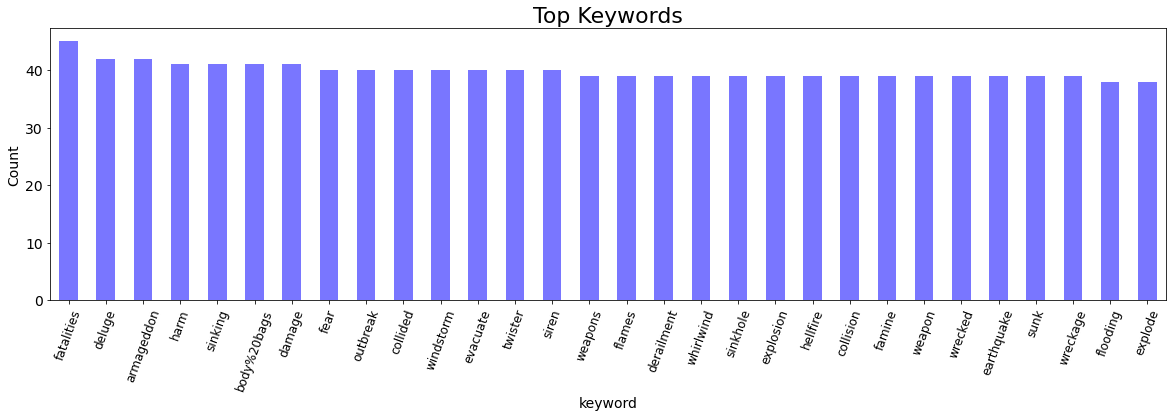

In [13]:
# Visualizing top 15 keywords

plt.figure(figsize=(20, 5))
df.keyword.value_counts().sort_values(ascending=False)[:30].plot(kind="bar",
                                                                  color="#7976FF",
                                                                  linewidth=2,
                                                                  fontsize=14);
plt.title('Top Keywords', fontsize = 22)
plt.xlabel('keyword', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.xticks(fontsize=12, rotation=70);

In [14]:
# Tweet cleaning function

def cleanText(text):
    text=re.sub(r'(@|#)[a-zA-Z0-9_]+','',text) # remove hashtags and usernames
    text=re.sub(r'https?:\/\/\S+',' ',text) # removing hyperlinks
    text=re.sub(r'\W',' ',text) # removing special characters
    text=re.sub(r'\d','',text) # removing special characters
    text=re.sub(r'(^\s+)','',text)  # removing space in front text 
    text=re.sub(r'(\s+$)','',text) # removing space in tail text 
    text=re.sub(r'\s[0-9]+\s','',text) # removing numbers
    text=text.lower() # making all text in lowercase
    
    return text

In [15]:
# Tweets processing function

def ProcessTweets(tweets):
    cleanTweets=[]
    for tweet in tweets:
        
        # Cleaning tweets
        tweet=cleanText(tweet)
        
        # Tokenization
        tweet=tweet.split()
        
        # Stemming
        ps = PorterStemmer()
        tweet=[ps.stem(word) for word in  tweet]
        
        cleanTweets.append(tweet)
        
    return cleanTweets

In [16]:
# Processing all tweets in the dataset

df['text'] = ProcessTweets(df['text'])

In [17]:
# Most common words in tweets

wordsCount = {}

for tweet in df['text']:
    
    for word in tweet:
        
        if word in stop_words:
            continue
        
        if word in wordsCount:
            wordsCount[word] += 1
        
        else:
            wordsCount[word] = 1

            
# Sorting the dictionary
N = 10
wordsCount = dict(sorted(wordsCount.items(), key=operator.itemgetter(1), reverse=True)[:N])
pd.DataFrame([wordsCount])

,thi,like,wa,fire,û_,amp,get,ha,bomb,new
0,483,410,393,358,344,344,311,256,237,226


In [18]:
# Most common stopwords words in tweets

nltk.download('stopwords')

stopWordsCount = {}

for tweet in df['text']:
    
    for word in tweet:
        
        if word not in stop_words:
            continue
            
        if word in stopWordsCount:
            stopWordsCount[word] += 1
            
        else:
            stopWordsCount[word] = 1

            
# Sorting the dictionary
N = 10
stopWordsCount = dict(sorted(stopWordsCount.items(), key=operator.itemgetter(1), reverse=True)[:N])
pd.DataFrame([stopWordsCount])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Moham\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,the,a,in,to,of,i,and,is,s,you
0,3276,2217,1985,1949,1831,1791,1427,949,924,902


In [19]:
# Removing Stopwords

tweet=[token for token in tweet if len(token) > 2  and token not in stop_words]

In [20]:
# Splitting positvie and negative tweets (indicates disaster = positive (1), does not indicate disaster = negative (0))

positiveTweets = []
negativeTweets = []

for i in range(len(df['target'])):
    if df['target'][i] == 1:
        positiveTweets.append(df['text'][i])
    
    elif df['target'][i] == 0:
        negativeTweets.append(df['text'][i])
               
print(len(positiveTweets))
print(len(negativeTweets))

3271
4342


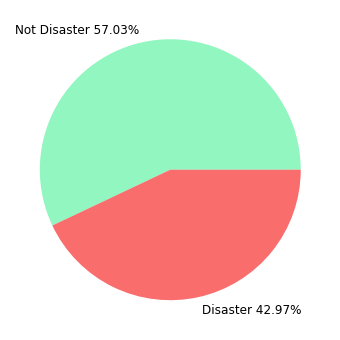

In [21]:
PosPerc = round((len(positiveTweets)/len(df['target']))*100,2)
NegPerc = round((len(negativeTweets)/len(df['target']))*100,2)
PosPerc = str(PosPerc)
NegPerc = str(NegPerc)

plt.figure(figsize=(18, 6))
df.target.value_counts().plot(kind="pie",
                              labels=["Not Disaster"+" "+NegPerc+"%", "Disaster"+" "+PosPerc+"%"],
                              colors=['#91F6C0', '#F96D6D'],
                              fontsize=12,
                              ylabel="");

In [22]:
# Creating WordCloud object to visualize positive and negative words

wc = WordCloud(width=800,
               height=400,
               max_words=200,
               stopwords=stop_words,
               background_color= "black", 
               colormap="Paired",
               max_font_size=150)


Word Cloud for Disaster Tweets


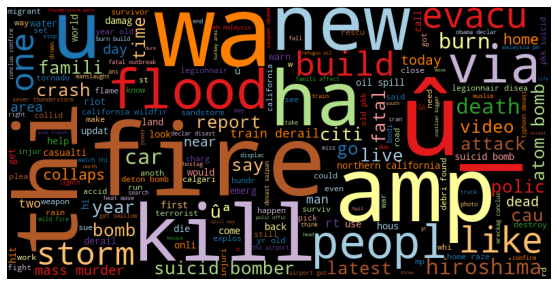


Word Cloud for Non-Disaster Tweets


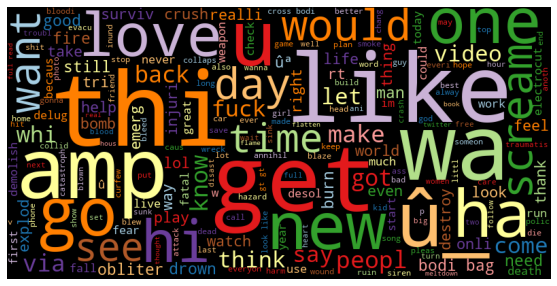

In [23]:
# Visualizing positive and negative indicating words

positiveTweetsList = ""
for tweet in positiveTweets:
    tweet = ' '.join(tweet)
    positiveTweetsList += tweet
    positiveTweetsList += " "
    
negativeTweetsList = ""
for tweet in negativeTweets:
    tweet = ' '.join(tweet)
    negativeTweetsList += tweet
    negativeTweetsList += " "

print('\033[1m'"\nWord Cloud for Disaster Tweets"'\033[0m')
wc.generate(positiveTweetsList)
plt.figure(figsize=(12, 5))
plt.imshow(wc)
plt.axis('off')
plt.show()

print('\033[1m'"\nWord Cloud for Non-Disaster Tweets"'\033[0m')
wc.generate(negativeTweetsList)
plt.figure(figsize=(12, 5))
plt.imshow(wc)
plt.axis('off')
plt.show()

### Conclusion:
 - 4342 of the tweets does not indicate a disaster, which is 57.03% of the data
 - 3271 of the tweets indicates a disaster, which is 42.97% of the data

In [24]:
tweets = []
labels = []
for i in range(len(positiveTweets)):
    if i < len(negativeTweets):
        tweets.append(positiveTweets[i])
        tweets.append(negativeTweets[i])
        labels.append(1)
        labels.append(0)
        
    else:
        tweets.append(positiveTweets[i])
        labels.append(1)

# Tokenization and Padding

In [25]:
# Tokenization

tokenizer=Tokenizer()
tokenizer.fit_on_texts(tweets)
sequence=tokenizer.texts_to_sequences(tweets)

# Checking the newly created sequence
sequence

[[136, 3270, 24, 1, 581, 5, 20, 162, 2224, 2660, 123, 47],
 [54, 9, 29, 119],
 [214, 23, 252, 622, 4523, 4524, 1232],
 [6, 115, 1573],
 [47,
  1327,
  623,
  4,
  1574,
  3,
  481,
  24,
  19,
  4525,
  16,
  268,
  43,
  261,
  89,
  64,
  1574,
  3,
  481,
  376,
  24,
  522],
 [442, 8, 115],
 [60, 2225, 89, 376, 3, 98],
 [14, 112, 8, 37, 723],
 [32, 132, 1166, 20, 233, 21, 4526, 31, 702, 21, 2661, 81, 2, 219],
 [54, 2, 4527],
 [269, 98, 1233, 388, 3, 724, 930, 501, 4, 1167, 377, 23],
 [20, 8, 1964],
 [747, 278, 146, 725, 71, 5, 502, 3, 4528, 1030, 789, 239],
 [972, 8, 538],
 [6, 35, 11, 279, 5, 1, 1094, 7, 6, 55, 113, 2, 23, 3, 1, 1747],
 [115, 3271],
 [72, 9, 45, 73, 89, 270, 57, 3, 1, 82, 931, 1, 502],
 [54, 2, 703, 91],
 [6, 35, 1965, 15, 1, 482, 8, 117, 4, 136, 239],
 [4529],
 [523, 60, 168, 21, 1, 303, 179, 37, 561],
 [43, 180, 6, 55, 22, 1433, 15, 293],
 [973,
  539,
  3272,
  8,
  38,
  71,
  2662,
  467,
  2,
  483,
  6,
  110,
  3,
  539,
  3272,
  54,
  234,
  6,
  401,
  

In [26]:
# Padding tweets so that all tweets have the same number of features

# Getting longest tweet
lenSequence=[len(tweet) for tweet in sequence]
maxLen=max(lenSequence)

# Increasing maxLen to prevent errors/deleting words if we got a longer tweet in testing
maxLen+=2

print("Maximum tweet length is: ",maxLen)

Maximum tweet length is:  35


In [27]:
# Padding sequences to make them all of length 35 (maxLen)

paddedSequence=pad_sequences(sequence,maxlen=maxLen)

# Checking the newly created paddedSequence
paddedSequence

array([[   0,    0,    0, ..., 2660,  123,   47],
       [   0,    0,    0, ...,    9,   29,  119],
       [   0,    0,    0, ..., 4523, 4524, 1232],
       ...,
       [   0,    0,    0, ...,   48,   59,  285],
       [   0,    0,    0, ...,  199,  671,   92],
       [   0,    0,    0, ...,   48,   59,  285]])

# Splitting tweets into train and test sets

In [28]:
# Splitting data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(paddedSequence, np.array(labels), test_size=0.1, random_state=0)

# Building the LSTM model

In [29]:
model=Sequential()
model.add(Embedding(10000,80,input_length=35))

model.add(LSTM(8))

model.add(Dense(6, activation='relu'))

model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 35, 80)            800000    
                                                                 
 lstm (LSTM)                 (None, 8)                 2848      
                                                                 
 dense (Dense)               (None, 6)                 54        
                                                                 
 dropout (Dropout)           (None, 6)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 802,909
Trainable params: 802,909
Non-trainable params: 0
_________________________________________________________________


In [30]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

history=model.fit(X_train, y_train, 
                  batch_size=32,
                  epochs=3,
                  validation_split=0.08,
                  shuffle=1)

Epoch 1/3
170/170 [==============================] - 5s 20ms/step - loss: 0.6295 - accuracy: 0.6706 - val_loss: 0.4483 - val_accuracy: 0.8153
Epoch 2/3
170/170 [==============================] - 3s 19ms/step - loss: 0.4232 - accuracy: 0.8257 - val_loss: 0.3557 - val_accuracy: 0.8471
Epoch 3/3
170/170 [==============================] - 3s 20ms/step - loss: 0.3186 - accuracy: 0.8829 - val_loss: 0.3542 - val_accuracy: 0.8684


# Visualizing model accuracy

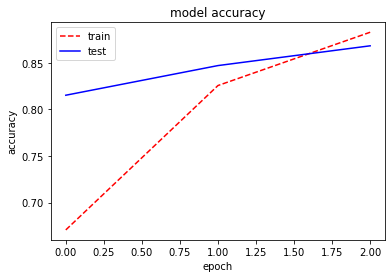

In [31]:
plt.plot(history.history['accuracy'],'r--')
plt.plot(history.history['val_accuracy'],'b-')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Testing and validating the model

In [32]:
model.evaluate(X_test,y_test)

21/21 [==============================] - 0s 4ms/step - loss: 0.4930 - accuracy: 0.7832


[0.49298250675201416, 0.7832061052322388]

In [33]:
# Reading test set

dfTest=pd.read_csv('test.csv')

In [34]:
# Processing test tweets

dfTest['text']=ProcessTweets(dfTest['text'])

In [35]:
#copying the tweets into a new list

tweetsTest = []
for i in range(len(dfTest['text'])):
    tweetsTest.append(dfTest['text'][i])

In [36]:
sequenceTest=tokenizer.texts_to_sequences(tweetsTest)
paddedSequenceTest=pad_sequences(sequenceTest,maxlen=maxLen)

In [37]:
# Prediction (validation)

model.predict(paddedSequenceTest)

102/102 [==============================] - 1s 3ms/step


array([[0.87784034],
       [0.45406038],
       [0.93540883],
       ...,
       [0.75263953],
       [0.74746436],
       [0.5378967 ]], dtype=float32)

# Saving the model

In [38]:
model.save("LSTM_model.h5")